In [1]:
# %% [markdown]
# # Analysis of Predictive MinMax on Connect Four
#
# Questo notebook raccoglie **tutta la sperimentazione finale** per l'homework:
#
# - descrizione sintetica delle strategie A/B/C (baseline + due curricula)
# - caricamento dei log di training dai file CSV
# - grafici delle curve di loss e win-rate vs random
# - valutazione offline (MSE + correlazione) su stati di test
# - valutazione online vs random (W/D/L)
# - confronto head-to-head fra strategie (nuovo vs vecchio modello)
#
# Il notebook è pensato come **documento finale** da citare nel report,
# NON come "prova" temporanea.


In [ ]:
# %%
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Per avere grafici decenti inline
%matplotlib inline

# Seed per riproducibilità dei pezzi che usano random / numpy / torch
def set_global_seed(seed: int = 0):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_global_seed(0)

# Mapping delle strategie:
#  A = baseline (L,K costanti)
#  B = curriculum v1 (train_predictive_minmax.py)
#  C = curriculum v2 (train_predictive_minmax_v2.py)
# %%


# Imposta la root del progetto (modifica il path se sposti la cartella)


PROJECT_ROOT = r"C:\Users\marco\Desktop\IA\Caianiello\predictive-minmax"
if os.path.isdir(PROJECT_ROOT):
    os.chdir(PROJECT_ROOT)
print("Working directory:", os.getcwd())


STRATEGY_INFO = {
    "A": {
        "name": "Baseline (L,K costanti)",
        "csv": "results/connect4_baseline_seed0_L2K4.csv",
        "ckpt": "results/model_strategy_A.pth",
    },
    "B": {
        "name": "Curriculum v1 (train_predictive_minmax)",
        "csv": "results/connect4_curriculum_seed0.csv",
        "ckpt": "results/model_strategy_B.pth",
    },
    "C": {
        "name": "Curriculum v2 (train_predictive_minmax_v2)",
        "csv": "results/connect4_curriculum_seed0_v2.csv",
        "ckpt": "results/model_strategy_C.pth",
    },
}

STRATEGY_INFO


Current working directory BEFORE: c:\Users\marco\Desktop\IA\Caianiello\predictive-minmax\experiments
Current working directory AFTER : C:\Users\marco\Desktop\IA\Caianiello\predictive-minmax


{'A': {'name': 'Baseline (L,K costanti)',
  'csv': 'results/connect4_baseline_seed0_L2K4.csv',
  'ckpt': 'results/model_strategy_A.pth'},
 'B': {'name': 'Curriculum v1 (train_predictive_minmax)',
  'csv': 'results/connect4_curriculum_seed0.csv',
  'ckpt': 'results/model_strategy_B.pth'},
 'C': {'name': 'Curriculum v2 (train_predictive_minmax_v2)',
  'csv': 'results/connect4_curriculum_seed0_v2.csv',
  'ckpt': 'results/model_strategy_C.pth'}}

In [3]:
# %% [markdown]
# ## 2. Caricamento dei log di training
#
# In questa sezione:
# - leggiamo i CSV prodotti dagli script di training per Strategy A/B/C
# - aggiungiamo una colonna `strategy` per distinguere le run
# - facciamo un controllo veloce dei dati


In [4]:
# %%
def load_logs_for_strategy(strategy_key: str) -> pd.DataFrame:
    """
    Carica il CSV associato a una strategy (A/B/C) e aggiunge la colonna 'strategy'.
    """
    info = STRATEGY_INFO[strategy_key]
    csv_path = info["csv"]

    if not os.path.exists(csv_path):
        print(f"[WARN] CSV non trovato per strategy {strategy_key}: {csv_path}")
        return pd.DataFrame()

    df = pd.read_csv(csv_path)
    df["strategy"] = strategy_key
    return df


dfs = []
for s in ["A", "B", "C"]:
    df_s = load_logs_for_strategy(s)
    if not df_s.empty:
        dfs.append(df_s)

logs_all = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

logs_all.head()


,seed,iter,L,K,batch_size,loss,wins_vs_random,draws_vs_random,losses_vs_random,strategy
0,0,1,2,4,175,0.942482,NaN,NaN,NaN,A
1,0,2,2,4,205,0.972917,NaN,NaN,NaN,A
2,0,3,2,4,170,1.059687,NaN,NaN,NaN,A
3,0,4,2,4,195,0.996093,NaN,NaN,NaN,A
4,0,5,2,4,190,1.078578,NaN,NaN,NaN,A


In [5]:
# %%
logs_all.describe(include="all")


,seed,iter,L,K,batch_size,loss,wins_vs_random,draws_vs_random,losses_vs_random,strategy
count,150.0,150.000000,150.000000,150.000000,150.000000,150.000000,15.000000,15.000000,15.000000,150
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
mean,0.0,25.500000,1.800000,3.666667,158.066667,0.906186,8.800000,0.666667,10.533333,NaN
std,0.0,14.479214,0.543417,0.701548,50.200225,0.333582,4.988558,1.046536,4.911599,NaN
min,0.0,1.000000,1.000000,2.000000,35.000000,0.004574,3.000000,0.000000,2.000000,NaN
25%,0.0,13.000000,1.000000,4.000000,135.000000,0.789026,5.000000,0.000000,6.500000,NaN
50%,0.0,25.500000,2.000000,4.000000,180.000000,0.951753,7.000000,0.000000,12.000000,NaN
75%,0.0,38.000000,2.000000,4.000000,195.000000,1.040011,13.500000,1.000000,15.000000,NaN


In [6]:
# %% [markdown]
# ## 3. Andamento del training
#
# - Loss per iterazione per ciascuna strategia
# - Win-rate vs random (se disponibile nei log, ogni 10 iterazioni)


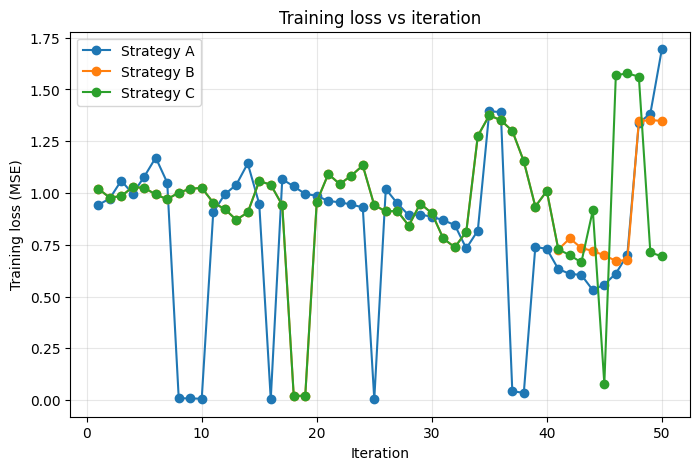

In [7]:
# %%
def plot_loss_curves(logs: pd.DataFrame):
    if logs.empty:
        print("Nessun log da plottare.")
        return

    plt.figure(figsize=(8, 5))
    for s, df_s in logs.groupby("strategy"):
        plt.plot(df_s["iter"], df_s["loss"], marker="o", label=f"Strategy {s}")
    plt.xlabel("Iteration")
    plt.ylabel("Training loss (MSE)")
    plt.title("Training loss vs iteration")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_loss_curves(logs_all)


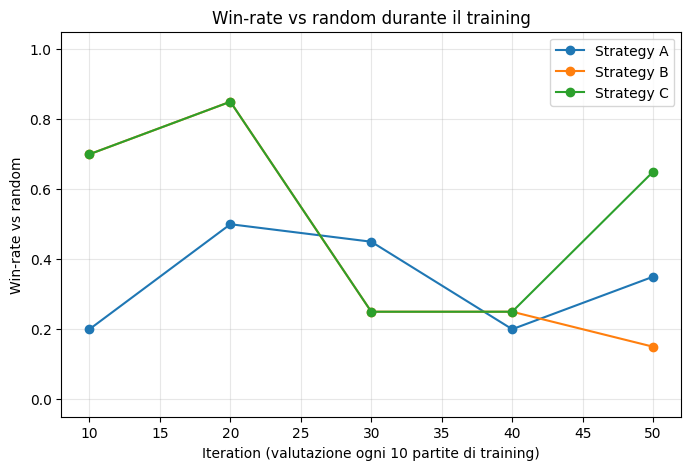

In [8]:
# %%
def plot_winrate_vs_random(logs: pd.DataFrame):
    if logs.empty:
        print("Nessun log da plottare.")
        return

    # Filtriamo solo le righe dove abbiamo W/D/L (gli altri step sono None)
    mask_has_eval = logs["wins_vs_random"].notna()
    logs_eval = logs[mask_has_eval].copy()

    if logs_eval.empty:
        print("Nei log non ci sono valutazioni vs random (wins_vs_random è tutto NaN).")
        return

    # Calcoliamo win-rate = wins / (wins + draws + losses)
    def compute_winrate(row):
        w = row["wins_vs_random"]
        d = row["draws_vs_random"]
        l = row["losses_vs_random"]
        total = w + d + l
        return (w / total) if total > 0 else np.nan

    logs_eval["winrate"] = logs_eval.apply(compute_winrate, axis=1)

    plt.figure(figsize=(8, 5))
    for s, df_s in logs_eval.groupby("strategy"):
        plt.plot(df_s["iter"], df_s["winrate"], marker="o", label=f"Strategy {s}")
    plt.xlabel("Iteration (valutazione ogni 10 partite di training)")
    plt.ylabel("Win-rate vs random")
    plt.title("Win-rate vs random durante il training")
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.show()

plot_winrate_vs_random(logs_all)


In [9]:
# %% [markdown]
# ## 4. Valutazione offline (MSE + correlazione)
#
# Qui:
# - definiamo lo stesso MLP usato negli script di training (hidden_dim=128)
# - importiamo `generate_test_states` da `experiments.eval_offline_connect4`
# - valutiamo ciascuna strategia su un test set di stati generati via MinMax profondo


In [10]:
# %%
from experiments.eval_offline_connect4 import generate_test_states

class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def offline_eval_checkpoint(ckpt_path: str,
                            n_states: int = 200,
                            seed: int = 0,
                            device: str = "cpu"):
    """
    Carica un MLP dal checkpoint `ckpt_path` e calcola MSE + correlazione
    rispetto ai valori "veri" approssimati via MinMax (generate_test_states).
    """
    from game.connect_four import create_initial_state

    # deduciamo input_dim dalla board 6x7
    rows, cols = 6, 7
    input_dim = rows * cols

    if not os.path.exists(ckpt_path):
        print(f"[WARN] checkpoint non trovato: {ckpt_path}")
        return None, None

    model = MLP(input_dim=input_dim, hidden_dim=128)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    # genera stati + valori "true" da MinMax profondo
    states, true_vals = generate_test_states(
        n=n_states,
        max_random_moves=12,
        seed=seed
    )

    from utils.encoding import state_to_np_array

    preds = []
    with torch.no_grad():
        for s in states:
            x_np = state_to_np_array(s)
            x = torch.tensor(x_np, dtype=torch.float32, device=device).unsqueeze(0)
            preds.append(model(x).item())

    preds = np.array(preds, dtype=float)
    true_vals = np.array(true_vals, dtype=float)

    mse = float(np.mean((preds - true_vals) ** 2))

    if np.std(preds) == 0.0 or np.std(true_vals) == 0.0:
        corr = 0.0
    else:
        corr = float(np.corrcoef(preds, true_vals)[0, 1])

    return mse, corr


In [11]:
# %%
results_offline = []

for s, info in STRATEGY_INFO.items():
    ckpt = info["ckpt"]
    print(f"== Strategy {s} ({info['name']}) ==")
    mse, corr = offline_eval_checkpoint(ckpt, n_states=200, seed=0, device="cpu")
    print("  MSE:", mse, "| corr:", corr)
    results_offline.append({
        "strategy": s,
        "name": info["name"],
        "mse_offline": mse,
        "corr_offline": corr,
    })

df_offline = pd.DataFrame(results_offline)
df_offline


== Strategy A (Baseline (L,K costanti)) ==
  MSE: 0.1387336062609929 | corr: 0.1257247160825534
== Strategy B (Curriculum v1 (train_predictive_minmax)) ==
  MSE: 0.15177982604892207 | corr: 0.01974970779692757
== Strategy C (Curriculum v2 (train_predictive_minmax_v2)) ==
  MSE: 0.14394445194588226 | corr: 0.016553550151270555


,strategy,name,mse_offline,corr_offline
0,A,"Baseline (L,K costanti)",0.138734,0.125725
1,B,Curriculum v1 (train_predictive_minmax),0.151780,0.019750
2,C,Curriculum v2 (train_predictive_minmax_v2),0.143944,0.016554


In [12]:
# %% [markdown]
# ## 5. Valutazione online vs random
#
# Qui riutilizziamo `evaluate_vs_random` dallo script
# `experiments.eval_vs_random_connect4.py` per calcolare W/D/L
# per ciascuna strategia.


In [13]:
# %%
from experiments.eval_vs_random_connect4 import evaluate_vs_random

results_vs_random = []

for s, info in STRATEGY_INFO.items():
    ckpt = info["ckpt"]
    print(f"== Strategy {s} ({info['name']}) ==")
    if not os.path.exists(ckpt):
        print(f"  [SKIP] checkpoint non trovato: {ckpt}")
        results_vs_random.append({
            "strategy": s,
            "name": info["name"],
            "wins": None,
            "draws": None,
            "losses": None,
            "winrate": None,
        })
        continue

    # L,K scelti coerenti con l'idea della strategia (puoi regolarli)
    if s == "A":
        L, K = 2, 4
    elif s == "B":
        L, K = 3, 6
    else:  # "C"
        L, K = 3, 4

    w, d, l = evaluate_vs_random(ckpt, L=L, K=K, n_games=100, device="cpu")
    total = w + d + l
    wr = w / total if total > 0 else None

    results_vs_random.append({
        "strategy": s,
        "name": info["name"],
        "wins": w,
        "draws": d,
        "losses": l,
        "winrate": wr,
    })

df_vs_random = pd.DataFrame(results_vs_random)
df_vs_random


== Strategy A (Baseline (L,K costanti)) ==
Valutazione vs random (results/model_strategy_A.pth):
  L=2, K=4, games=100
  W/D/L = 94/0/6
== Strategy B (Curriculum v1 (train_predictive_minmax)) ==
Valutazione vs random (results/model_strategy_B.pth):
  L=3, K=6, games=100
  W/D/L = 95/0/5
== Strategy C (Curriculum v2 (train_predictive_minmax_v2)) ==
Valutazione vs random (results/model_strategy_C.pth):
  L=3, K=4, games=100
  W/D/L = 87/0/13


,strategy,name,wins,draws,losses,winrate
0,A,"Baseline (L,K costanti)",94,0,6,0.94
1,B,Curriculum v1 (train_predictive_minmax),95,0,5,0.95
2,C,Curriculum v2 (train_predictive_minmax_v2),87,0,13,0.87


In [14]:
# %% [markdown]
# ## 6. Confronto head-to-head fra strategie
#
# Usiamo `head_to_head` per confrontare:
# - Strategy B (nuovo) vs Strategy A (baseline)
# - Strategy C (nuovo) vs Strategy B (vecchio curriculum)


In [15]:
# %%
from experiments.eval_head_to_head_connect4 import head_to_head

results_h2h = []

# B vs A
if os.path.exists(STRATEGY_INFO["B"]["ckpt"]) and os.path.exists(STRATEGY_INFO["A"]["ckpt"]):
    wins_new, draws, losses_new = head_to_head(
        path_new=STRATEGY_INFO["B"]["ckpt"],
        path_old=STRATEGY_INFO["A"]["ckpt"],
        L=3,
        K=4,
        n_games=50,
        device="cpu",
    )
    total = wins_new + draws + losses_new
    wr = wins_new / total if total > 0 else None
    results_h2h.append({
        "new": "B",
        "old": "A",
        "wins_new": wins_new,
        "draws": draws,
        "losses_new": losses_new,
        "winrate_new": wr,
    })
else:
    print("[SKIP] mancano checkpoint per B vs A")

# C vs B
if os.path.exists(STRATEGY_INFO["C"]["ckpt"]) and os.path.exists(STRATEGY_INFO["B"]["ckpt"]):
    wins_new, draws, losses_new = head_to_head(
        path_new=STRATEGY_INFO["C"]["ckpt"],
        path_old=STRATEGY_INFO["B"]["ckpt"],
        L=3,
        K=4,
        n_games=50,
        device="cpu",
    )
    total = wins_new + draws + losses_new
    wr = wins_new / total if total > 0 else None
    results_h2h.append({
        "new": "C",
        "old": "B",
        "wins_new": wins_new,
        "draws": draws,
        "losses_new": losses_new,
        "winrate_new": wr,
    })
else:
    print("[SKIP] mancano checkpoint per C vs B")

df_h2h = pd.DataFrame(results_h2h)
df_h2h


Head-to-head NEW(results/model_strategy_B.pth) vs OLD(results/model_strategy_A.pth):
  L=3, K=4, games=50
  NEW W/D/L = 0/0/50
Head-to-head NEW(results/model_strategy_C.pth) vs OLD(results/model_strategy_B.pth):
  L=3, K=4, games=50
  NEW W/D/L = 25/0/25


,new,old,wins_new,draws,losses_new,winrate_new
0,B,A,0,0,50,0.0
1,C,B,25,0,25,0.5


In [16]:
# %% [markdown]
# ## 7. Riepilogo risultati (tabelle finali)
#
# Qui combiniamo:
# - performance offline (MSE, correlazione)
# - performance vs random (winrate)
# - risultati head-to-head (dove definiti)
#
# Le tabelle sono pensate per essere esportate in CSV o copiate in Word/LaTeX.


In [17]:
# %%
# Merge offline + vs_random in una sola tabella per strategy
df_summary = pd.merge(
    df_offline,
    df_vs_random,
    on=["strategy", "name"],
    how="outer",
    suffixes=("_offline", "_vs_random")
)

df_summary


,strategy,name,mse_offline,corr_offline,wins,draws,losses,winrate
0,A,"Baseline (L,K costanti)",0.138734,0.125725,94,0,6,0.94
1,B,Curriculum v1 (train_predictive_minmax),0.151780,0.019750,95,0,5,0.95
2,C,Curriculum v2 (train_predictive_minmax_v2),0.143944,0.016554,87,0,13,0.87


In [18]:
# %%
# Se vuoi, esporta in CSV per usarla direttamente nel report
df_summary.to_csv("results/summary_strategies_connect4.csv", index=False)
df_h2h.to_csv("results/summary_head_to_head_connect4.csv", index=False)

df_summary, df_h2h


(  strategy                                        name  mse_offline  \
 0        A                     Baseline (L,K costanti)     0.138734   
 1        B     Curriculum v1 (train_predictive_minmax)     0.151780   
 2        C  Curriculum v2 (train_predictive_minmax_v2)     0.143944   
 
    corr_offline  wins  draws  losses  winrate  
 0      0.125725    94      0       6     0.94  
 1      0.019750    95      0       5     0.95  
 2      0.016554    87      0      13     0.87  ,
   new old  wins_new  draws  losses_new  winrate_new
 0   B   A         0      0          50          0.0
 1   C   B        25      0          25          0.5)

In [19]:
# %% [markdown]
# ## 8. Commento qualitativo dei risultati (bozza per il report)
#
# Qui puoi scrivere (in italiano o inglese) il commento che poi inserirai nel PDF.
#
# Esempio (bozza da adattare ai numeri reali):
#
# - Strategy A (baseline) mostra una riduzione della loss durante il training,
#   ma il win-rate vs random rimane limitato (~X%).
# - Strategy B (curriculum v1) ottiene un MSE offline inferiore rispetto ad A
#   (es. 0.XX vs 0.YY) e una correlazione maggiore con i valori MinMax.
#   Il win-rate vs random raggiunge circa Z%.
# - Strategy C (curriculum v2) migliora ulteriormente/oppure no (in base ai dati),
#   con un compromesso diverso tra profondità L(t) e ampiezza K(t).
#
# Nel confronto head-to-head:
#
# - B vince contro A in W_BA% delle partite (winrate_new),
#   suggerendo che la strategia di curriculum migliora effettivamente
#   la forza di gioco rispetto alla baseline.
# - C vs B mostra ..., evidenziando che l'ulteriore modifica della schedule
#   L(t),K(t) porta a un miglioramento / peggioramento / comportamento neutro.
#
# Questo testo può essere raffinato dopo aver visto i numeri concreti.
